In [3]:
import os
import cv2
import json
import torch
import numpy as np
import supervision as sv
import pycocotools.mask as mask_util
from pathlib import Path
from torchvision.ops import box_convert
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from grounding_dino.groundingdino.util.inference import load_model, load_image, predict

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


All libraries imported successfully!
PyTorch version: 2.7.1+cu128
CUDA available: True


In [13]:
# Text prompt for object detection (IMPORTANT: must be lowercase and end with a dot)
# TEXT_PROMPT = "car. tire."

TEXT_PROMPT = "Terethereal shadow work tarot card deck | beautiful antique victorian gothic tarot cards deck."

# Input image path
# IMG_PATH = "notebooks/images/truck.jpg"

IMG_PATH = "notebooks/images/erethereal_tarot_1.jpg"

# SAM2 model configuration
SAM2_CHECKPOINT = "./checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"

# Grounding DINO configuration
GROUNDING_DINO_CONFIG = "grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "gdino_checkpoints/groundingdino_swint_ogc.pth"

# Detection thresholds
BOX_THRESHOLD = 0.35  # Confidence threshold for bounding boxes
TEXT_THRESHOLD = 0.25 # Confidence threshold for text matching

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Output settings
OUTPUT_DIR = Path("outputs/grounded_sam2_local_demo")
DUMP_JSON_RESULTS = True

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration set!")
print(f"Device: {DEVICE}")
print(f"Text prompt: {TEXT_PROMPT}")
print(f"Image: {IMG_PATH}")
print(f"Output directory: {OUTPUT_DIR}")


Configuration set!
Device: cuda
Text prompt: Terethereal shadow work tarot card deck | beautiful antique victorian gothic tarot cards deck.
Image: notebooks/images/erethereal_tarot_1.jpg
Output directory: outputs\grounded_sam2_local_demo


In [14]:
print("Loading SAM2 model...")
# Build SAM2 image predictor
sam2_model = build_sam2(SAM2_MODEL_CONFIG, SAM2_CHECKPOINT, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)
print("✅ SAM2 model loaded successfully!")

print("\nLoading Grounding DINO model...")
# Build grounding dino model
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)
print("✅ Grounding DINO model loaded successfully!")

print("\n🎉 Both models are ready for inference!")


Loading SAM2 model...
✅ SAM2 model loaded successfully!

Loading Grounding DINO model...
final text_encoder_type: bert-base-uncased
✅ Grounding DINO model loaded successfully!

🎉 Both models are ready for inference!


Loading image: notebooks/images/erethereal_tarot_1.jpg


Image loaded successfully!
Image dimensions: 1588 x 1588


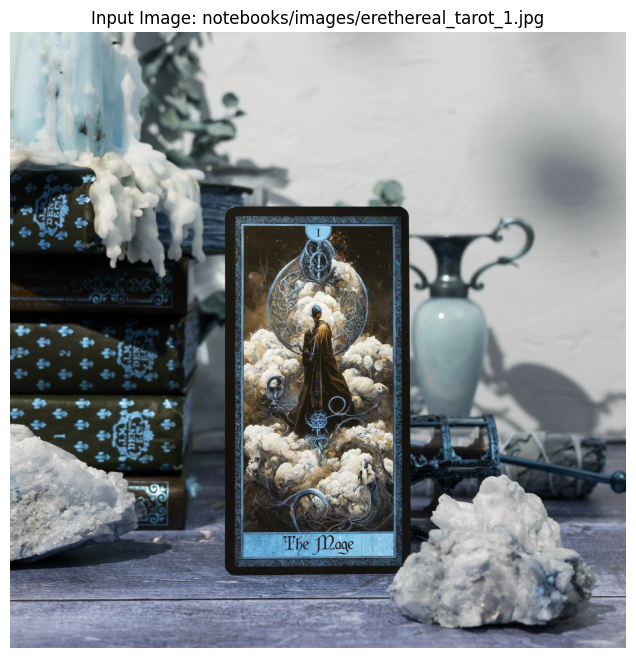

In [15]:
# Load image for processing
print(f"Loading image: {IMG_PATH}")
image_source, image = load_image(IMG_PATH)

# Set image for SAM2 predictor
sam2_predictor.set_image(image_source)

# Get image dimensions
h, w, _ = image_source.shape
print(f"Image loaded successfully!")
print(f"Image dimensions: {w} x {h}")

# Display the original image
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
plt.title(f"Input Image: {IMG_PATH}")
plt.axis('off')
plt.show()


In [16]:
print(f"Running Grounding DINO with prompt: '{TEXT_PROMPT}'")
print(f"Box threshold: {BOX_THRESHOLD}, Text threshold: {TEXT_THRESHOLD}")

# Run Grounding DINO inference
boxes, confidences, labels = predict(
    model=grounding_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=DEVICE
)

print(f"\n🎯 Detection Results:")
print(f"Number of objects detected: {len(boxes)}")
print(f"Labels: {labels}")
print(f"Confidences: {[f'{conf:.3f}' for conf in confidences.tolist()]}")

# Process the box coordinates for SAM2
# Convert from normalized coordinates to absolute coordinates
boxes = boxes * torch.Tensor([w, h, w, h])
# Convert from center format (cxcywh) to corner format (xyxy)
input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

print(f"\nProcessed bounding boxes for SAM2:")
for i, (box, label, conf) in enumerate(zip(input_boxes, labels, confidences)):
    print(f"  {i+1}. {label}: [{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}] (conf: {conf:.3f})")


Running Grounding DINO with prompt: 'Terethereal shadow work tarot card deck | beautiful antique victorian gothic tarot cards deck.'
Box threshold: 0.35, Text threshold: 0.25



🎯 Detection Results:
Number of objects detected: 1
Labels: ['beautiful antique victorian gothic tarot cards deck']
Confidences: ['0.461']

Processed bounding boxes for SAM2:
  1. beautiful antique victorian gothic tarot cards deck: [550.4, 446.1, 1031.4, 1397.6] (conf: 0.461)


In [17]:
print("Running SAM2 for segmentation...")

# Enable autocast for better performance on modern GPUs
torch.autocast(device_type=DEVICE, dtype=torch.bfloat16).__enter__()

if torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8:
    # Enable tfloat32 for Ampere GPUs for better performance
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# Run SAM2 prediction using the detected boxes as prompts
masks, scores, logits = sam2_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

# Post-process masks
if masks.ndim == 4:
    masks = masks.squeeze(1)

print(f"✅ SAM2 segmentation completed!")
print(f"Generated {len(masks)} segmentation masks")
print(f"Mask shape: {masks.shape}")
print(f"Segmentation scores: {[f'{score:.3f}' for score in scores.flatten().tolist()]}")


Running SAM2 for segmentation...
✅ SAM2 segmentation completed!
Generated 1 segmentation masks
Mask shape: (1, 1588, 1588)
Segmentation scores: ['0.992']


In [18]:
# Prepare data for visualization
confidences_list = confidences.numpy().tolist()
class_names = labels
class_ids = np.array(list(range(len(class_names))))

# Create labels with confidence scores
visualization_labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence in zip(class_names, confidences_list)
]

# Load image for visualization
img = cv2.imread(IMG_PATH)

# Create supervision detections object
detections = sv.Detections(
    xyxy=input_boxes,  # (n, 4)
    mask=masks.astype(bool),  # (n, h, w)
    class_id=class_ids
)

print("Creating visualizations...")


Creating visualizations...


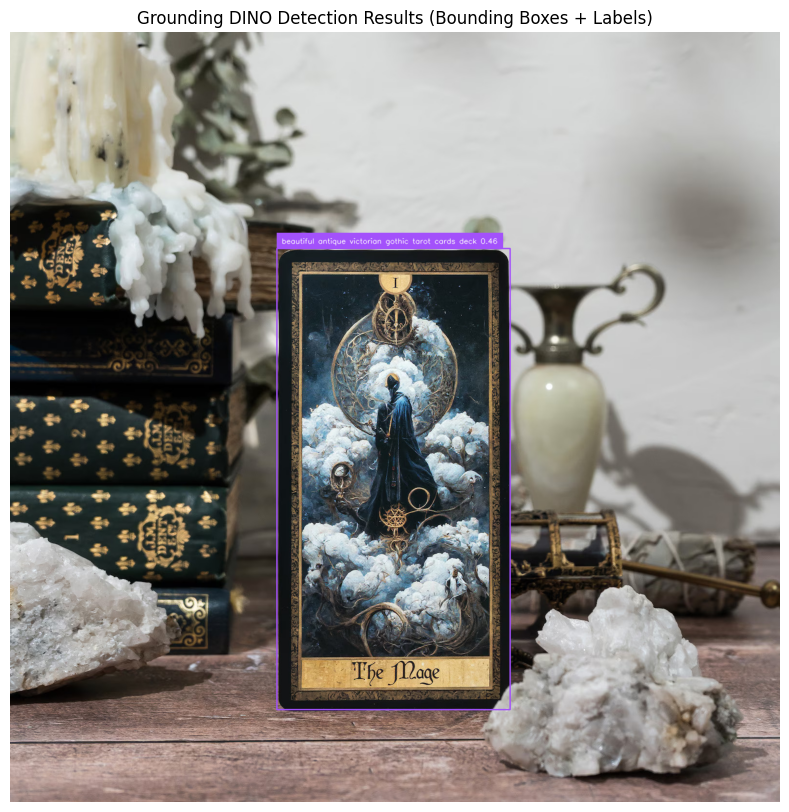

Bounding box visualization saved to: outputs\grounded_sam2_local_demo\groundingdino_annotated_image.jpg


In [19]:
# Create bounding box visualization
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

label_annotator = sv.LabelAnnotator()
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, 
    detections=detections, 
    labels=visualization_labels
)

# Save and display
bbox_output_path = os.path.join(OUTPUT_DIR, "groundingdino_annotated_image.jpg")
cv2.imwrite(bbox_output_path, annotated_frame)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.title("Grounding DINO Detection Results (Bounding Boxes + Labels)")
plt.axis('off')
plt.show()

print(f"Bounding box visualization saved to: {bbox_output_path}")


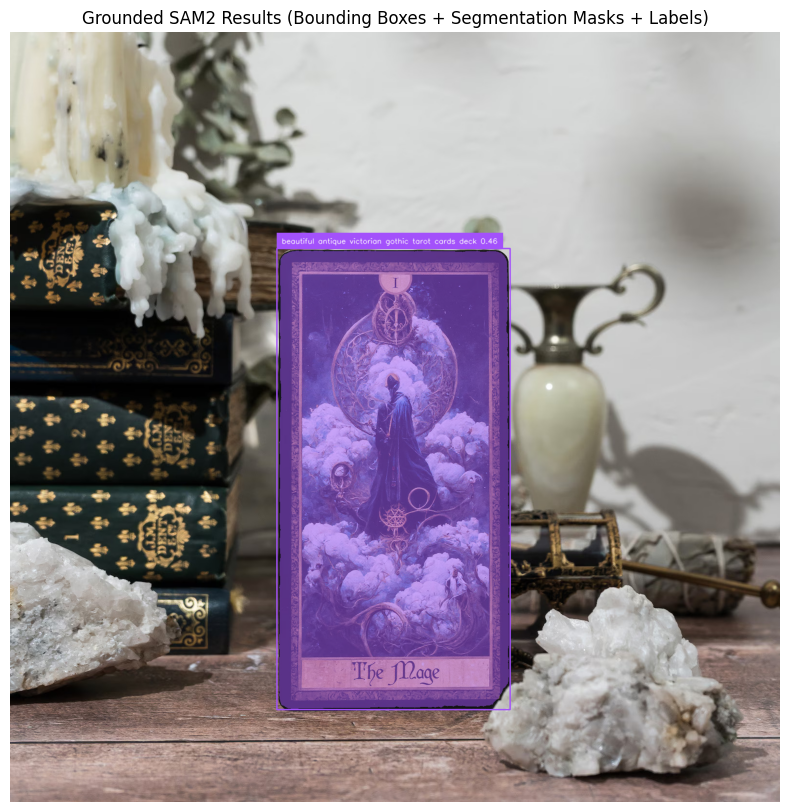

Segmentation visualization saved to: outputs\grounded_sam2_local_demo\grounded_sam2_annotated_image_with_mask.jpg


In [20]:
# Create mask visualization
mask_annotator = sv.MaskAnnotator()
masked_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)

# Save and display
mask_output_path = os.path.join(OUTPUT_DIR, "grounded_sam2_annotated_image_with_mask.jpg")
cv2.imwrite(mask_output_path, masked_frame)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(masked_frame, cv2.COLOR_BGR2RGB))
plt.title("Grounded SAM2 Results (Bounding Boxes + Segmentation Masks + Labels)")
plt.axis('off')
plt.show()

print(f"Segmentation visualization saved to: {mask_output_path}")


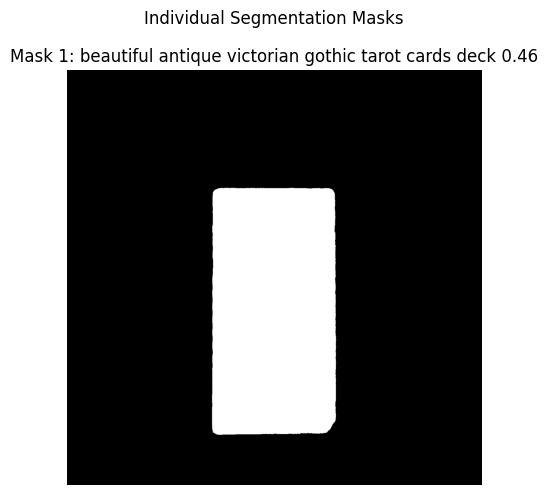

In [21]:
# Show individual masks
if len(masks) > 0:
    fig, axes = plt.subplots(1, len(masks), figsize=(5*len(masks), 5))
    if len(masks) == 1:
        axes = [axes]
    
    for i, (mask, label) in enumerate(zip(masks, visualization_labels)):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f"Mask {i+1}: {label}")
        axes[i].axis('off')
    
    plt.suptitle("Individual Segmentation Masks")
    plt.tight_layout()
    plt.show()
else:
    print("No masks to display")


In [22]:
def single_mask_to_rle(mask):
    """Convert a single mask to RLE (Run Length Encoding) format."""
    rle = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

if DUMP_JSON_RESULTS:
    print("Preparing results for JSON export...")
    
    # Convert masks to RLE format (compressed representation)
    mask_rles = [single_mask_to_rle(mask) for mask in masks]

    # Convert to Python native types
    input_boxes_list = input_boxes.tolist()
    scores_list = scores.tolist()
    
    # Create structured results
    results = {
        "image_path": IMG_PATH,
        "text_prompt": TEXT_PROMPT,
        "detection_params": {
            "box_threshold": BOX_THRESHOLD,
            "text_threshold": TEXT_THRESHOLD
        },
        "annotations": [
            
            {
                "class_name": class_name,
                "bbox": box,
                "segmentation": mask_rle,
                "detection_score": det_conf,
                "segmentation_score": seg_score,
            }
            for class_name, box, mask_rle, det_conf, seg_score in zip(
                class_names, input_boxes_list, mask_rles, confidences_list, scores_list
            )
        ],
        "metadata": {
            "box_format": "xyxy",
            "img_width": w,
            "img_height": h,
            "num_detections": len(class_names),
            "device": DEVICE
        }
    }
    
    # Save results
    json_output_path = os.path.join(OUTPUT_DIR, "grounded_sam2_local_image_demo_results.json")
    with open(json_output_path, "w") as f:
        json.dump(results, f, indent=4)
    
    print(f"✅ Results saved to: {json_output_path}")
    print(f"\n📊 Summary:")
    print(f"  - Image: {IMG_PATH}")
    print(f"  - Detected objects: {len(class_names)}")
    print(f"  - Classes: {', '.join(class_names)}")
    print(f"  - Output directory: {OUTPUT_DIR}")
else:
    print("JSON export skipped (DUMP_JSON_RESULTS=False)")


Preparing results for JSON export...
✅ Results saved to: outputs\grounded_sam2_local_demo\grounded_sam2_local_image_demo_results.json

📊 Summary:
  - Image: notebooks/images/erethereal_tarot_1.jpg
  - Detected objects: 1
  - Classes: beautiful antique victorian gothic tarot cards deck
  - Output directory: outputs\grounded_sam2_local_demo
